# NLP Project
# AI Detection

## Loading libraries

In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.utils import resample
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

#Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis (EDA) & Preprocessing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


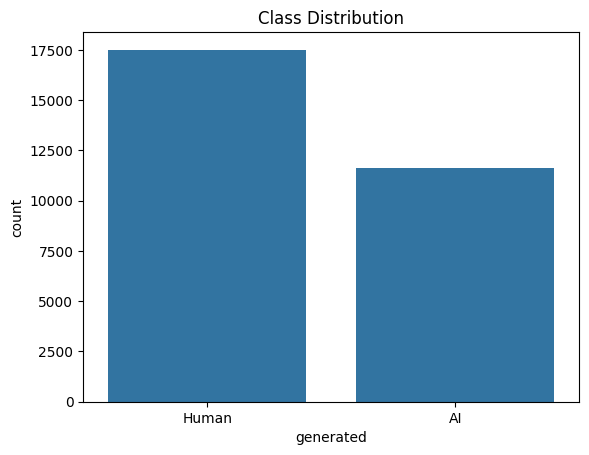

In [4]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IA653_Final_Project/Training_Essay_Data.csv')
data.info()
data['generated'] = data['generated'].astype(int)

data.isnull().sum()
data.dropna(subset=['text'], inplace=True)

sns.countplot(x='generated', data=data)
plt.title('Class Distribution')
labels = {0: "Human", 1: "AI"}
plt.xticks(ticks=[0, 1], labels=[labels[0], labels[1]])
plt.show()


## Words and Vocabulary


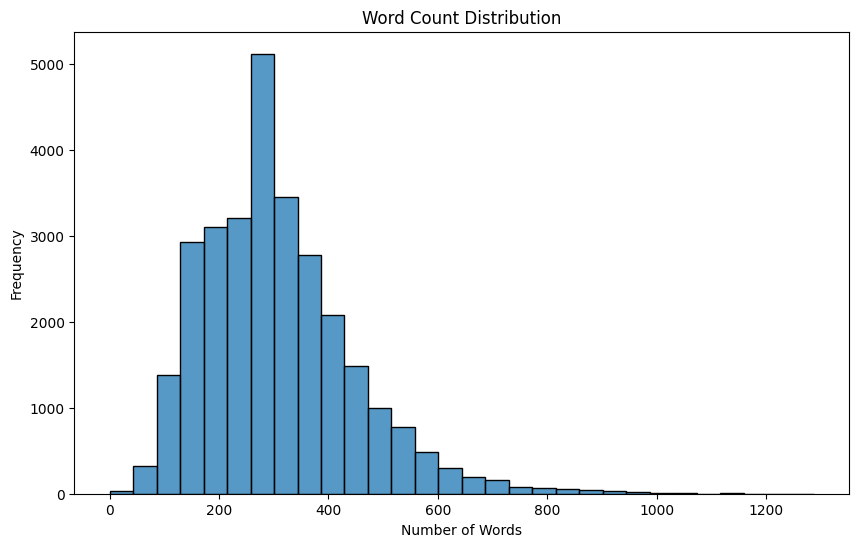

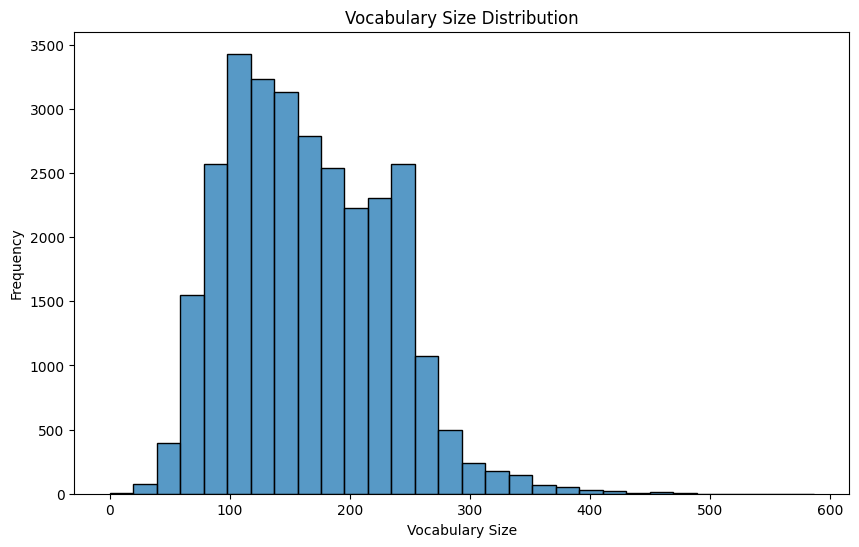

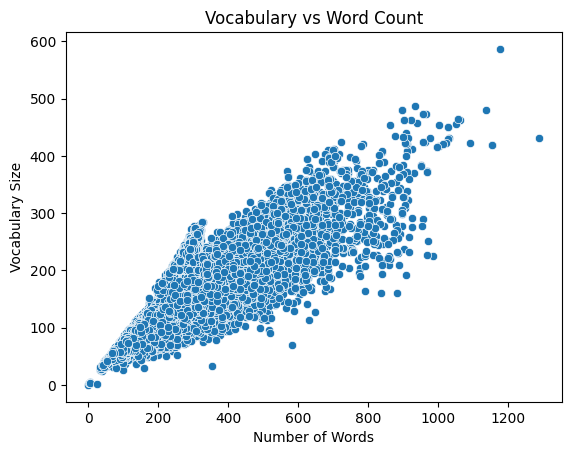

<ipython-input-5-2f2aeb13d616>:39: RuntimeWarning: divide by zero encountered in log
  log_words = np.log(n_words)
<ipython-input-5-2f2aeb13d616>:40: RuntimeWarning: divide by zero encountered in log
  log_vocab = np.log(n_vocab)


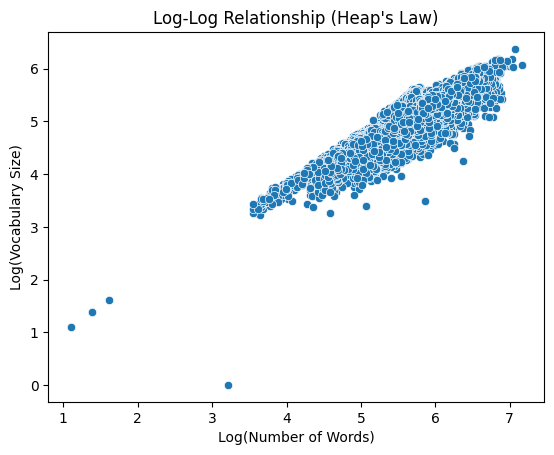

In [5]:
def get_vocab_and_words(text):
    word_regex = re.compile(r'\b[A-Za-z]{3,}\b')
    words = word_regex.findall(text)
    v = len(set(words))
    n = len(words)
    return v, n

n_words = []
n_vocab = []

for text in data['text']:
    v, n = get_vocab_and_words(text)
    n_vocab.append(v)
    n_words.append(n)

data['vocab_size'] = n_vocab
data['word_count'] = n_words

plt.figure(figsize=(10,6))
sns.histplot(data['word_count'], bins=30)
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data['vocab_size'], bins=30)
plt.title('Vocabulary Size Distribution')
plt.xlabel('Vocabulary Size')
plt.ylabel('Frequency')
plt.show()

sns.scatterplot(x=n_words, y=n_vocab)
plt.title("Vocabulary vs Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Vocabulary Size")
plt.show()

log_words = np.log(n_words)
log_vocab = np.log(n_vocab)
sns.scatterplot(x=log_words, y=log_vocab)
plt.title("Log-Log Relationship (Heap's Law)")
plt.xlabel("Log(Number of Words)")
plt.ylabel("Log(Vocabulary Size)")
plt.show()


## Text Normalization

                                                text  \
0  Car-free cities have become a subject of incre...   
1  Car Free Cities  Car-free cities, a concept ga...   
2    A Sustainable Urban Future  Car-free cities ...   
3    Pioneering Sustainable Urban Living  In an e...   
4    The Path to Sustainable Urban Living  In an ...   

                                     normalized_text  \
0  city become subject increasing interest debate...   
1  car free city city concept gaining traction co...   
2  sustainable urban future city emerging powerfu...   
3  pioneering sustainable urban living era marked...   
4  path sustainable urban living age rapid urbani...   

                                           sentences  
0  [Car-free cities have become a subject of incr...  
1  [Car Free Cities  Car-free cities, a concept g...  
2  [  A Sustainable Urban Future  Car-free cities...  
3  [  Pioneering Sustainable Urban Living  In an ...  
4  [  The Path to Sustainable Urban Living  In an..

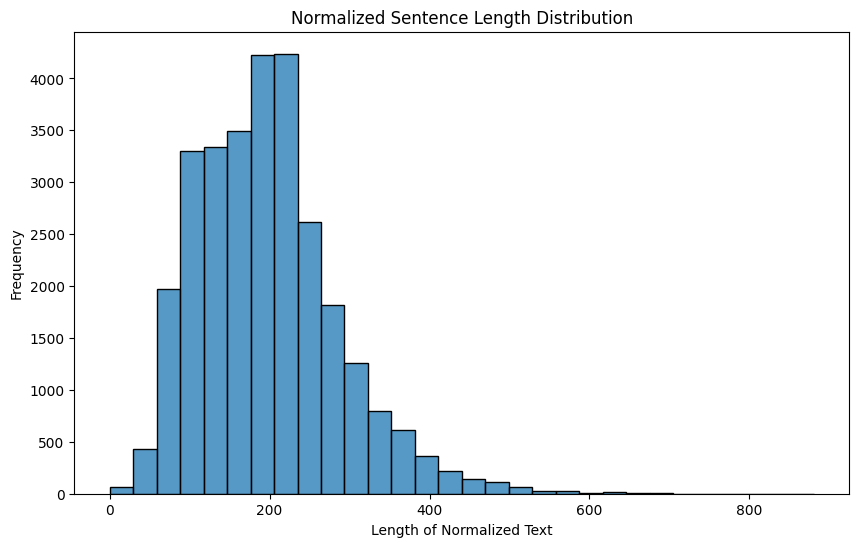

In [6]:
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    normalized_text = ' '.join(tokens)
    return normalized_text

def segment_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

data['normalized_text'] = data['text'].apply(normalize_text)
data['sentences'] = data['text'].apply(segment_sentences)

print(data[['text', 'normalized_text', 'sentences']].head())

data['normalized_text_length'] = data['normalized_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(data['normalized_text_length'], bins=30)
plt.title('Normalized Sentence Length Distribution')
plt.xlabel('Length of Normalized Text')
plt.ylabel('Frequency')
plt.show()


## N-grams

<ipython-input-7-8e94e64db665>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=ai_bigram_df, palette='Blues_d')
<ipython-input-7-8e94e64db665>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=human_bigram_df, palette='Oranges_d')
<ipython-input-7-8e94e64db665>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Trigram', data=ai_trigram_df, palette='Blues_d')
<ipython-input-7-8e94e64db665>:48: FutureWarning: 

Passing `palette` without assigning `hue` is depre

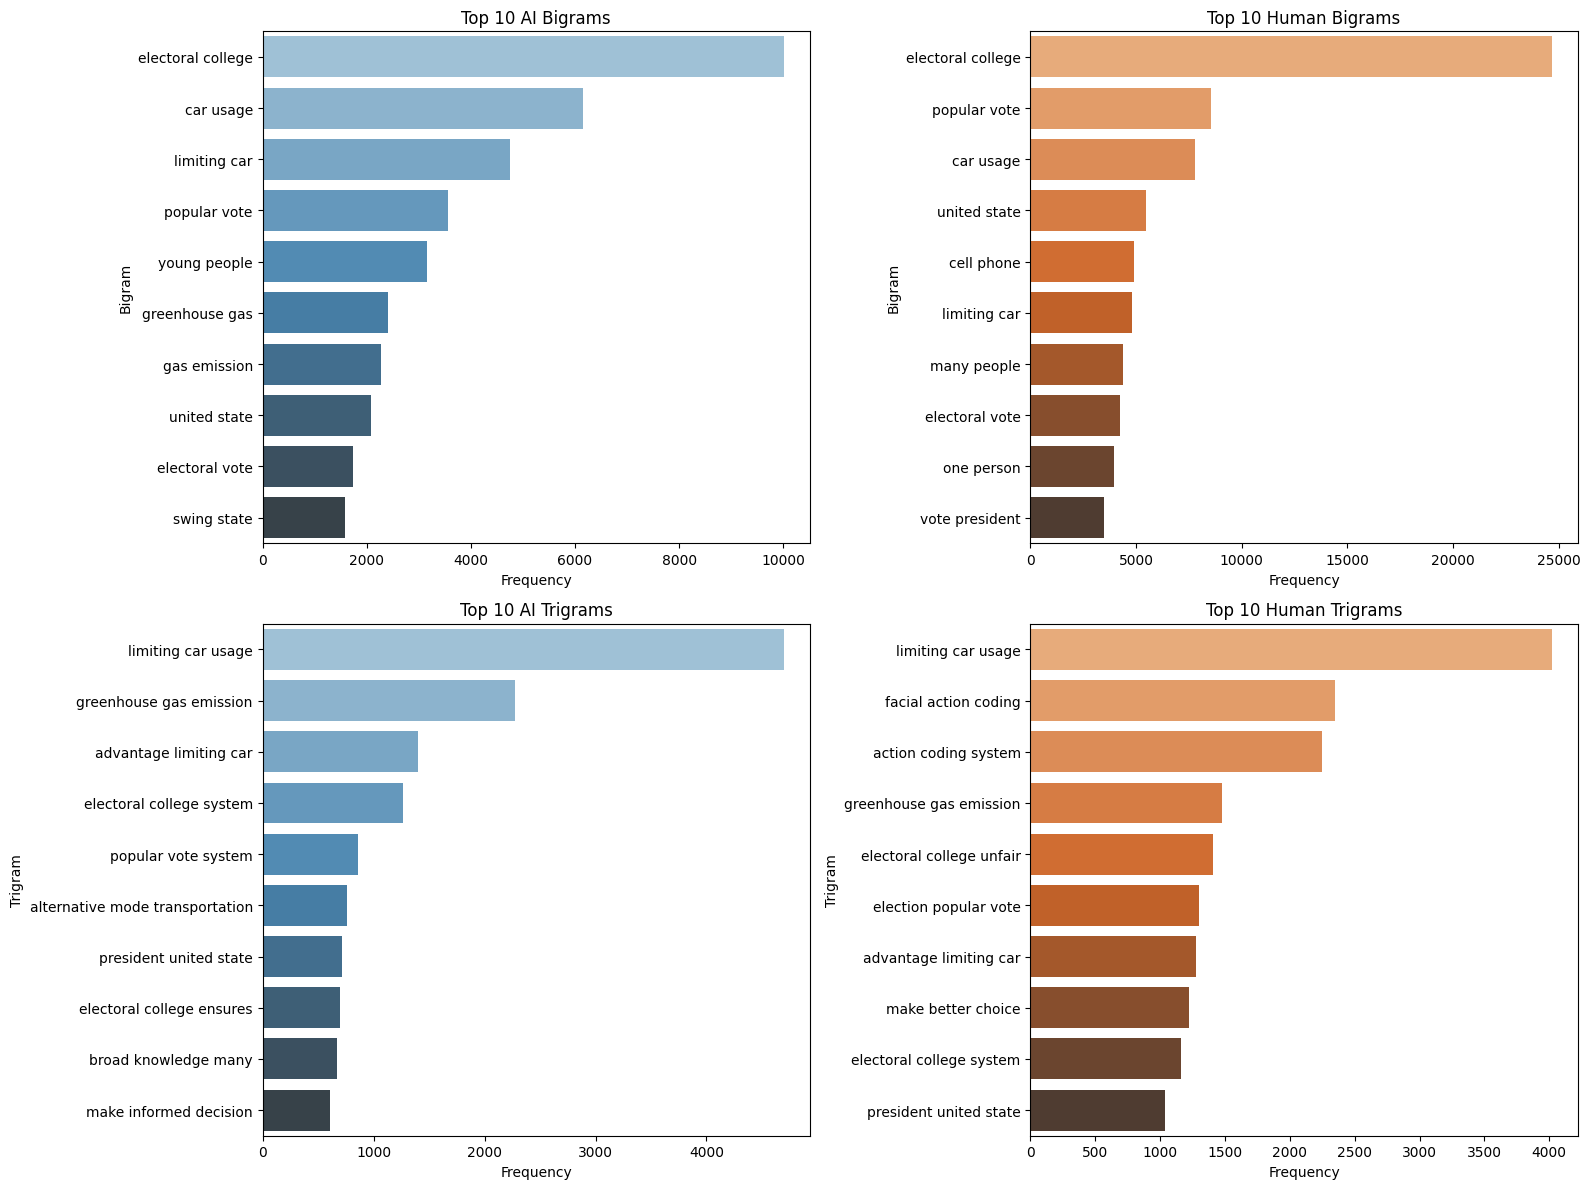

In [7]:
def get_ngrams(text, n=2):
    tokens = text.split()
    n_grams = ngrams(tokens, n)
    return [' '.join(ngram) for ngram in n_grams]

data['bigrams'] = data['normalized_text'].apply(lambda x: get_ngrams(x, n=2))
data['trigrams'] = data['normalized_text'].apply(lambda x: get_ngrams(x, n=3))

ai_bigrams = [bigram for sublist in data[data['generated'] == 1]['bigrams'] for bigram in sublist]
human_bigrams = [bigram for sublist in data[data['generated'] == 0]['bigrams'] for bigram in sublist]

ai_trigrams = [trigram for sublist in data[data['generated'] == 1]['trigrams'] for trigram in sublist]
human_trigrams = [trigram for sublist in data[data['generated'] == 0]['trigrams'] for trigram in sublist]

ai_bigram_counts = Counter(ai_bigrams)
human_bigram_counts = Counter(human_bigrams)

ai_trigram_counts = Counter(ai_trigrams)
human_trigram_counts = Counter(human_trigrams)

top_ai_bigrams = ai_bigram_counts.most_common(10)
top_human_bigrams = human_bigram_counts.most_common(10)

top_ai_trigrams = ai_trigram_counts.most_common(10)
top_human_trigrams = human_trigram_counts.most_common(10)

ai_bigram_df = pd.DataFrame(top_ai_bigrams, columns=['Bigram', 'Frequency'])
human_bigram_df = pd.DataFrame(top_human_bigrams, columns=['Bigram', 'Frequency'])

ai_trigram_df = pd.DataFrame(top_ai_trigrams, columns=['Trigram', 'Frequency'])
human_trigram_df = pd.DataFrame(top_human_trigrams, columns=['Trigram', 'Frequency'])

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.barplot(x='Frequency', y='Bigram', data=ai_bigram_df, palette='Blues_d')
plt.title('Top 10 AI Bigrams')

plt.subplot(2, 2, 2)
sns.barplot(x='Frequency', y='Bigram', data=human_bigram_df, palette='Oranges_d')
plt.title('Top 10 Human Bigrams')

plt.subplot(2, 2, 3)
sns.barplot(x='Frequency', y='Trigram', data=ai_trigram_df, palette='Blues_d')
plt.title('Top 10 AI Trigrams')

plt.subplot(2, 2, 4)
sns.barplot(x='Frequency', y='Trigram', data=human_trigram_df, palette='Oranges_d')
plt.title('Top 10 Human Trigrams')

plt.tight_layout()
plt.show()


## Creating Word Embeddings using Word2Vec


In [8]:
data['tokens'] = data['normalized_text'].apply(word_tokenize)

word2vec_model = Word2Vec(sentences=data['tokens'],
                          vector_size=100,
                          window=5,
                          min_count=2,
                          workers=4,
                          sg=0)

word2vec_model.save("word2vec_model")
print(word2vec_model.wv.most_similar("ai", topn=10))
print(word2vec_model.wv.most_similar("human", topn=10))

[('intelligence', 0.6632723808288574), ('automation', 0.655403733253479), ('iot', 0.6478567123413086), ('robotics', 0.6304415464401245), ('robotic', 0.6160324215888977), ('sophisticated', 0.6036075949668884), ('computing', 0.5936124324798584), ('artificial', 0.5911941528320312), ('telephone', 0.5809386968612671), ('gprethanks', 0.5743780136108398)]
[('sentient', 0.5899204611778259), ('humankind', 0.45312702655792236), ('humas', 0.44269242882728577), ('intelligent', 0.43784213066101074), ('unnessacary', 0.43157827854156494), ('bottomless', 0.4205004870891571), ('scientist', 0.41795259714126587), ('machine', 0.4123608469963074), ('extraterrestrial', 0.41149821877479553), ('physiology', 0.40540871024131775)]


## Visualizing Word Embeddings with PCA


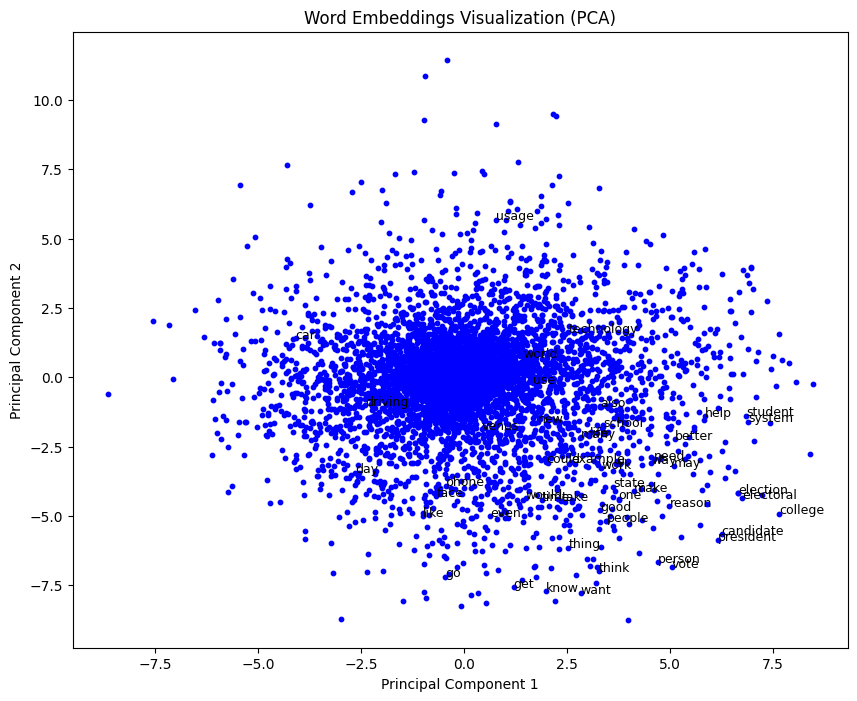

In [9]:
word_vectors = word2vec_model.wv
vocab = list(word_vectors.index_to_key)
X = word_vectors[vocab]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', s=10, color='blue')
for i, word in enumerate(vocab[:50]):
    plt.annotate(word, xy=(X_pca[i, 0], X_pca[i, 1]), fontsize=9)
plt.title("Word Embeddings Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


## Using Embeddings as Features


In [10]:
def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

data['doc_vector'] = data['tokens'].apply(lambda x: document_vector(x, word2vec_model))

X = np.stack(data['doc_vector'].values)
y = data['generated']

print("Feature matrix shape:", X.shape)


Feature matrix shape: (29145, 100)


# Naive Bayes vs Logistic Regression

### Naive Bayes

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['normalized_text'], y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_tfidf, y_train)

nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)

y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Results")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Results
Accuracy: 0.9716932578486875
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3539
           1       0.96      0.96      0.96      2290

    accuracy                           0.97      5829
   macro avg       0.97      0.97      0.97      5829
weighted avg       0.97      0.97      0.97      5829



### Logistic Regression

In [12]:
X_train_docvec, X_test_docvec, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_docvec, y_train)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_balanced, y_train_balanced)

y_pred_lr = lr_model.predict(X_test_docvec)
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results
Accuracy: 0.9722079258878024
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3539
           1       0.96      0.97      0.96      2290

    accuracy                           0.97      5829
   macro avg       0.97      0.97      0.97      5829
weighted avg       0.97      0.97      0.97      5829



### Metrics Comparison

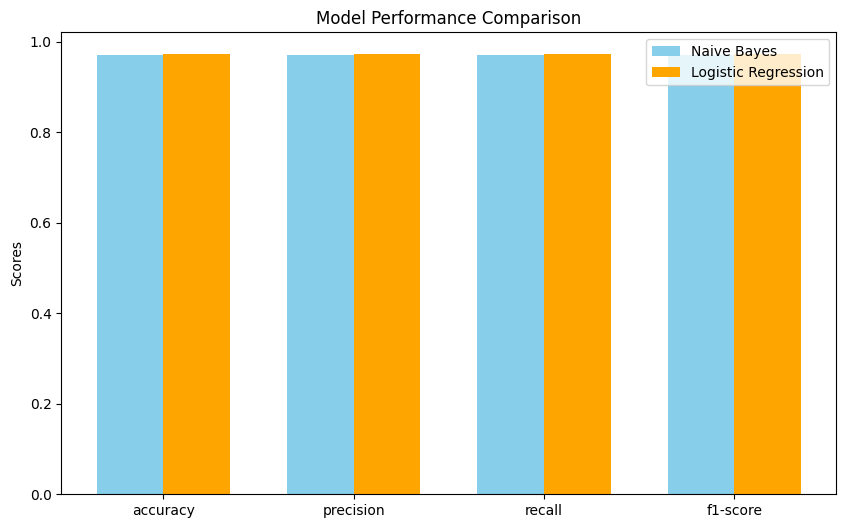

In [13]:
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)

nb_df = pd.DataFrame(nb_report).transpose()
lr_df = pd.DataFrame(lr_report).transpose()

metrics = ['accuracy', 'precision', 'recall', 'f1-score']
nb_scores = [accuracy_score(y_test, y_pred_nb), nb_df.loc['weighted avg', 'precision'],
             nb_df.loc['weighted avg', 'recall'], nb_df.loc['weighted avg', 'f1-score']]

lr_scores = [accuracy_score(y_test, y_pred_lr), lr_df.loc['weighted avg', 'precision'],
             lr_df.loc['weighted avg', 'recall'], lr_df.loc['weighted avg', 'f1-score']]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, nb_scores, width, label='Naive Bayes', color='skyblue')
plt.bar(x + width/2, lr_scores, width, label='Logistic Regression', color='orange')

plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


### Confusion Matrix Comparison

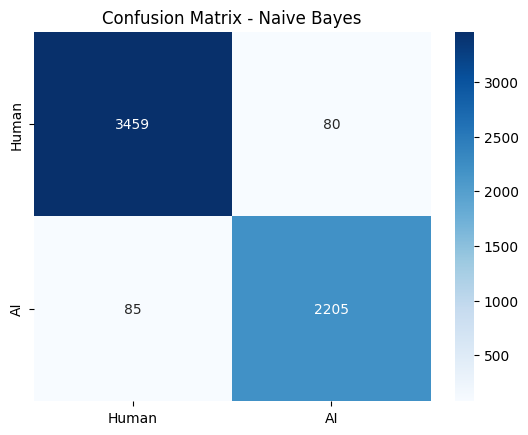

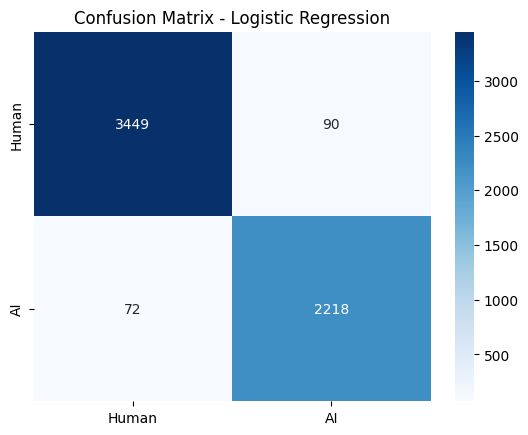

In [14]:
cm_nn = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

cm_lstm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Neural Networks

### Basic Feedforward Neural Network

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

model_basic = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True)

model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_nn = model_basic.fit(X_train_balanced, y_train_balanced, validation_split=0.2, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

y_pred_nn = (model_basic.predict(X_test) > 0.5).astype("int32")
print("Neural Network Results")
print(classification_report(y_test, y_pred_nn))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8968 - loss: 0.2441 - val_accuracy: 0.9465 - val_loss: 0.1588
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9714 - loss: 0.0883 - val_accuracy: 0.9658 - val_loss: 0.1012
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9774 - loss: 0.0711 - val_accuracy: 0.9687 - val_loss: 0.0854
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9794 - loss: 0.0623 - val_accuracy: 0.9663 - val_loss: 0.0840
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9796 - loss: 0.0613 - val_accuracy: 0.9634 - val_loss: 0.1051
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9825 - loss: 0.0539 - val_accuracy: 0.9810 - val_loss: 0.0546
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9862 - loss: 0.0445 - val_accuracy: 0.9754 - val_loss: 0.0718
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0374 - val_accuracy: 0.9706 - val_

#### Loss Curve

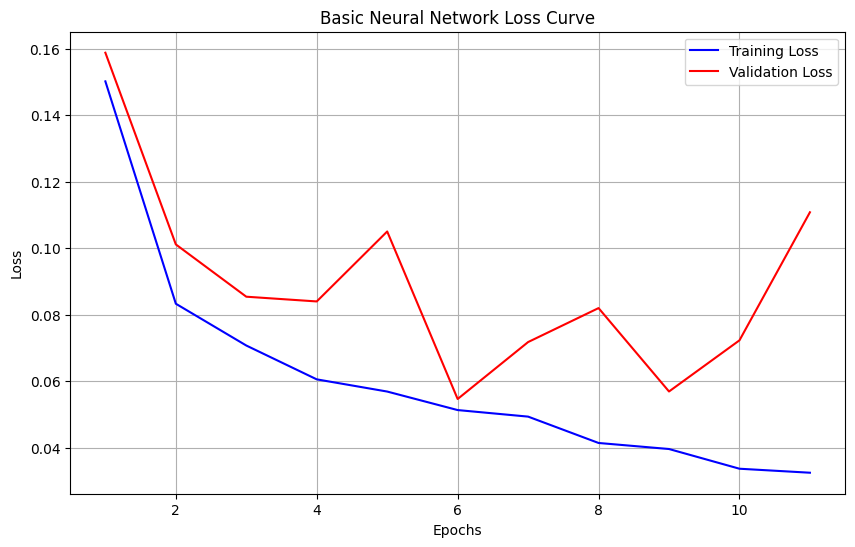

In [16]:
train_loss_nn = history_nn.history['loss']
val_loss_nn = history_nn.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_nn)+1), train_loss_nn, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss_nn)+1), val_loss_nn, label='Validation Loss', color='red')
plt.title('Basic Neural Network Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### LSTM

In [17]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['normalized_text'])

sequences = tokenizer.texts_to_sequences(data['normalized_text'])

max_length = 128
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y = data['generated'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

vocab_size = 10000
embedding_dim = 128
input_length = max_length

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True)

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

history_lstm = model_lstm.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred_lstm))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 127s 265ms/step - accuracy: 0.8392 - loss: 0.3608 - val_accuracy: 0.9230 - val_loss: 0.2847
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 123s 264ms/step - accuracy: 0.9806 - loss: 0.0802 - val_accuracy: 0.9818 - val_loss: 0.0650
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 121s 259ms/step - accuracy: 0.9899 - loss: 0.0386 - val_accuracy: 0.9692 - val_loss: 0.1140
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 144s 263ms/step - accuracy: 0.9948 - loss: 0.0222 - val_accuracy: 0.9722 - val_loss: 0.1158
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accuracy: 0.9966 - loss: 0.0136 - val_accuracy: 0.9829 - val_loss: 0.0826
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 120s 257ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9864 - val_loss: 0.0574
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 144s 261ms/step - accuracy: 0.9952 - loss: 0.0178 - val_accuracy: 0.9719 - val_loss: 0.1138
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 143s 263ms/step - accuracy: 0.9970 -

#### Loss Curve

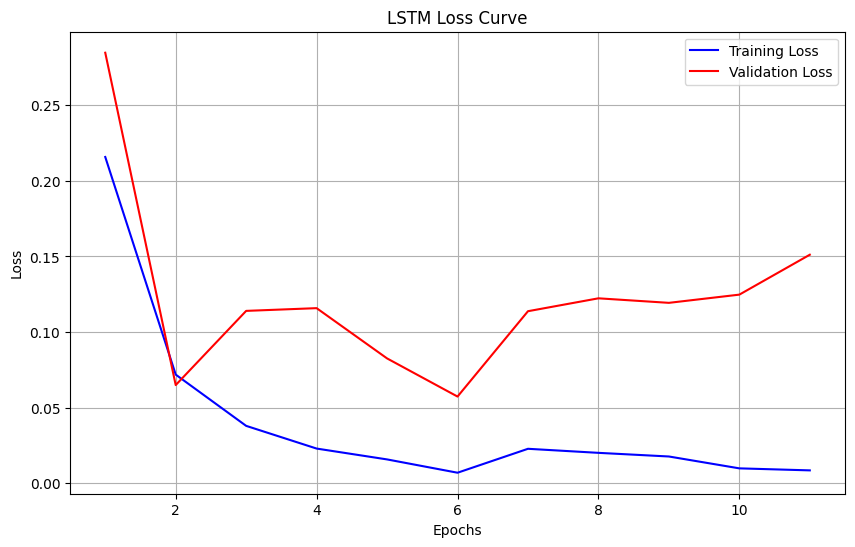

In [18]:
train_loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_lstm)+1), train_loss_lstm, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss_lstm)+1), val_loss_lstm, label='Validation Loss', color='red')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Metrics Comparison

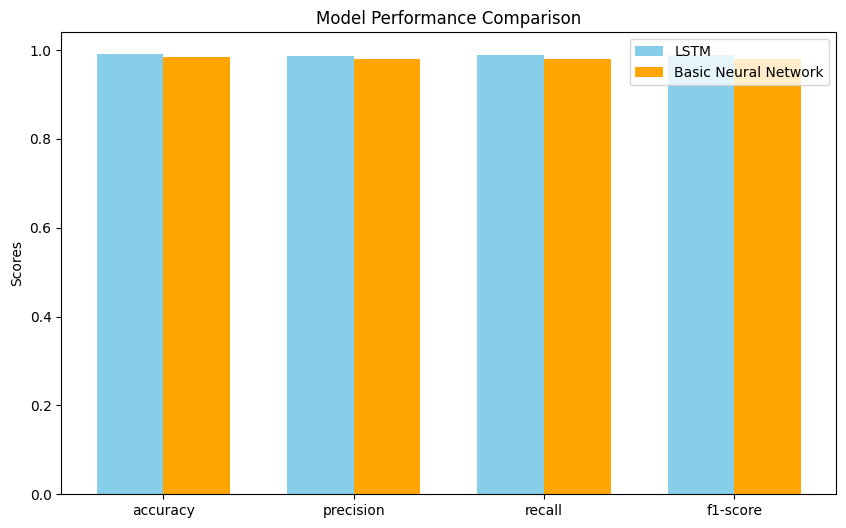

In [19]:
def get_metrics(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1-score': f1_score(y_true, y_pred)
    }
    return metrics

lstm_metrics = get_metrics(y_test, y_pred_lstm, "LSTM")

nn_metrics = get_metrics(y_test, y_pred_nn, "Basic Neural Network")

metrics = ['accuracy', 'precision', 'recall', 'f1-score']

lstm_scores = [lstm_metrics['accuracy'], lstm_metrics['precision'], lstm_metrics['recall'], lstm_metrics['f1-score']]
nn_scores = [nn_metrics['accuracy'], nn_metrics['precision'], nn_metrics['recall'], nn_metrics['f1-score']]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, lstm_scores, width, label='LSTM', color='skyblue')
plt.bar(x + width/2, nn_scores, width, label='Basic Neural Network', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


### Confusion Matrix Comparison

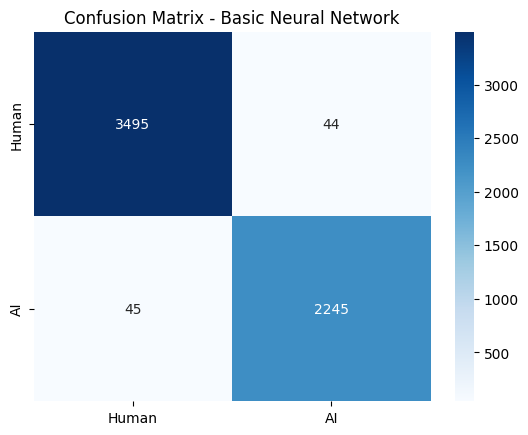

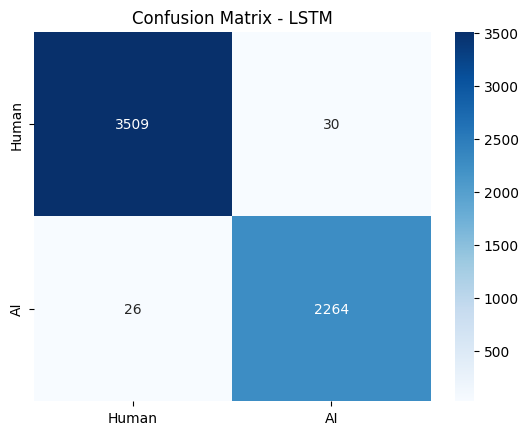

In [20]:
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Basic Neural Network")
plt.show()

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - LSTM")
plt.show()

# Sample Predictions

In [21]:
def preprocess_samples(model_type, samples, tokenizer=None, max_length=128, tfidf_vectorizer=None):
    if model_type == "lstm":
        samples = [' '.join(map(str, sample)) for sample in samples]
        sequences = tokenizer.texts_to_sequences(samples)
        return pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    elif model_type == "basic_nn":
        return samples
    elif model_type == "logistic":
        return samples
    elif model_type == "naive":
        return samples
    else:
        raise ValueError("Unsupported model type. Use 'lstm', 'basic_nn', 'logistic', or 'naive'.")

def test_random_samples(model, X_test, y_test, model_type="basic_nn", tokenizer=None, max_length=128, tfidf_vectorizer=None):
    print("-"*50)
    print(f"Samples For {model_type}:")
    num_samples = 4
    random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

    if model_type == "basic_nn":
        X_random_samples = np.stack(data['doc_vector'].values)[random_indices]
    else:
        X_random_samples = X_test[random_indices]

    y_random_true = y_test[random_indices]

    if model_type == "lstm":
        X_random_samples = preprocess_samples(model_type, X_random_samples, tokenizer=tokenizer, max_length=max_length)
    elif model_type == "logistic" or model_type == "naive":
        pass

    if hasattr(X_random_samples, 'toarray'):
        X_random_samples = X_random_samples.toarray()

    y_pred = model.predict(X_random_samples)

    if model_type == "lstm" or model_type == "basic_nn":
        if y_pred.shape[-1] == 1:
            y_pred = (y_pred > 0.5).astype("int32")
        else:
            y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = np.round(y_pred).astype("int32")

    for i in range(num_samples):
        print(f"Sample {i + 1}")
        print("True Label:", "Human" if y_random_true[i] == 0 else "AI")
        print("Predicted Label:", "Human" if y_pred[i] == 0 else "AI")
        print("-" * 30)

test_random_samples(model_lstm, X_test, y_test, model_type="lstm", tokenizer=tokenizer, max_length=128)
test_random_samples(model_basic, X_test, y_test, model_type="basic_nn")
test_random_samples(lr_model, X_test_docvec, y_test, model_type="logistic")
test_random_samples(nb_model, X_test_tfidf, y_test, model_type="naive")

--------------------------------------------------
Samples For lstm:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 1
True Label: AI
Predicted Label: Human
------------------------------
Sample 2
True Label: Human
Predicted Label: Human
------------------------------
Sample 3
True Label: AI
Predicted Label: Human
------------------------------
Sample 4
True Label: Human
Predicted Label: Human
------------------------------
--------------------------------------------------
Samples For basic_nn:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample 1
True Label: Human
Predicted Label: Human
------------------------------
Sample 2
True Label: Human
Predicted Label: Human
------------------------------
Sample 3
True Label: Human
Predicted Label: Human
------------------------------
Sample 4
True Label: AI
Predicted Label: Human
------------------------------
--------------------------------------------------
Samples For logistic:
Sample 1
True Label: AI
Predicted Label: AI
--------------------------

### New Samples

In [22]:
ai_text = '''
The Electoral College: A Deep Dive into Its Mechanisms, Controversies, and Future
The Electoral College is one of the most talked-about, yet often misunderstood, elements of the American political system. It is a mechanism by which the United States elects its president, and its unique structure has been both praised and criticized over the years. The system’s origins, how it operates, and its implications for democracy and representation have made it a persistent topic of debate. This essay will explore the history of the Electoral College, its operational details, the arguments for and against it, and potential paths for reform.
Historical Background
The Electoral College was established in Article II, Section 1 of the U.S. Constitution, with the goal of creating a buffer between the general population and the selection of a president. The framers of the Constitution were concerned about direct democracy and feared that voters might be too swayed by popular sentiment or charisma over qualifications and governance expertise. The system was intended to be a compromise between electing the president by a vote of Congress and a direct popular election.
At the Constitutional Convention of 1787, the delegates debated the issue of how to best elect a president. They eventually settled on a system in which each state would have a certain number of electors equal to its number of representatives in Congress (the sum of its Senate and House members). These electors would be chosen by the states, and they would cast votes for president and vice president.
The Electoral College system has evolved over time. Initially, electors were selected by state legislatures, but this practice changed as states moved to a popular vote system for choosing electors in the 19th century. The process has remained largely unchanged since the 19th century, with the exception of the 12th Amendment in 1804, which refined the procedure for electing the president and vice president.
How the Electoral College Works
The Electoral College consists of 538 electors. Each state’s allocation of electors is based on its representation in Congress, which is determined by the number of its Senators (always 2) plus the number of its Representatives in the House. Washington, D.C., which has no voting representation in Congress, is given 3 electors by the 23rd Amendment.
When voters cast their ballots in a presidential election, they are actually voting for a slate of electors chosen by the political parties. These electors then cast their votes for president and vice president. Most states use a winner-take-all system, where the candidate who wins the majority of the popular vote in that state receives all of its electoral votes. Maine and Nebraska are exceptions; they use a proportional system where electoral votes are distributed based on congressional district outcomes.
To win the presidency, a candidate must secure a majority of the electoral votes—at least 270 out of 538. If no candidate receives a majority, the election is decided in the House of Representatives, where each state delegation has one vote. This happened once in U.S. history in the election of 1800 (which was later decided by the House as the election was tied between Thomas Jefferson and Aaron Burr) and was a significant factor in the election of 1824, which John Quincy Adams won.
The Pros and Cons of the Electoral College
The Electoral College is a divisive issue, with strong arguments on both sides. Proponents argue that it has several key benefits, while critics highlight its shortcomings and call for reform.
Arguments in Favor
Protection of Smaller States' Interests: One of the primary arguments for the Electoral College is that it ensures smaller states have a voice in presidential elections. Without this system, presidential campaigns would focus exclusively on the most populous states, potentially ignoring the needs and concerns of smaller states.
Stability and Clear Outcomes: The Electoral College can lead to more decisive election outcomes. By concentrating the campaign focus on swing states, it encourages candidates to build broad coalitions that can appeal to a diverse set of voters. This can lead to more stable governance and prevent a candidate who wins by a narrow margin nationwide from assuming office.
Encouragement of National Campaigns: The system pushes candidates to campaign in a variety of states rather than just focusing on highly populated urban areas. This helps foster a national perspective on political issues rather than just regional interests.
Arguments Against
Disproportionate Representation: Critics argue that the Electoral College gives disproportionate power to smaller states. For example, a vote in Wyoming carries significantly more weight than a vote in California due to the number of electors per capita. This undermines the principle of "one person, one vote" and leads to unequal representation.
Potential for a Minority President: The Electoral College has produced presidents who did not win the popular vote. This has occurred in five elections, most recently in 2016, when Donald Trump defeated Hillary Clinton despite losing the popular vote by nearly 3 million votes. This can lead to questions about the legitimacy of a president's mandate.
Focus on Swing States: The Electoral College system creates an environment where only a handful of states (often referred to as "swing states" or "battleground states") receive significant attention from candidates. States like Florida, Pennsylvania, and Michigan are key battlegrounds, while solidly red or blue states may be ignored, which can lead to unequal attention to voters' concerns.
Risk of "Faithless Electors": While rare, electors are not legally bound to vote for the candidate they pledged to support. This has led to concerns that electors could potentially vote against the will of their state’s voters and alter election outcomes, though this has happened only a handful of times in U.S. history.
Electoral College in Practice: Impact on Elections
The Electoral College’s practical impact has been significant in shaping the outcomes of presidential elections. While it is designed to be an equalizer, in practice, it results in campaigns that focus intensely on a few key states, leading to uneven representation and policy considerations.
In the 2016 presidential election, the debate over the Electoral College’s impact was intensified. Donald Trump won the presidency by securing 304 electoral votes to Hillary Clinton's 227, despite losing the popular vote by almost 2.9 million votes. This outcome reignited debates over the legitimacy of the Electoral College and whether it aligns with democratic principles.
In contrast, the 2000 election between George W. Bush and Al Gore is another case that highlights the Electoral College’s controversial nature. Gore won the popular vote by over 500,000 votes but lost the Electoral College due to a narrow win in Florida, which secured Bush’s victory. The outcome led to a Supreme Court decision (Bush v. Gore) that effectively decided the election, raising questions about the fairness and transparency of the system.
Reforming the Electoral College
Given the controversies, there have been multiple proposals for reforming the Electoral College. These range from constitutional amendments to state-level changes in how electors are allocated.
National Popular Vote Interstate Compact (NPVIC)
One prominent proposal is the National Popular Vote Interstate Compact. This agreement among participating states pledges that their electors will cast their votes for the candidate who wins the national popular vote, regardless of the outcome in their own states. The compact only goes into effect once states totaling at least 270 electoral votes sign on. This approach seeks to maintain the Electoral College system while ensuring the popular vote winner becomes president.
Abolishing the Electoral College
Another proposed reform is to abolish the Electoral College altogether and move to a direct popular vote system. This would align the outcome of presidential elections with the overall national vote count, eliminating the risk of electing a president without a popular majority. However, this would require a constitutional amendment, which is difficult and rare, as it requires a two-thirds majority in both the House and the Senate or a constitutional convention called by two-thirds of the state legislatures.
Conclusion
The Electoral College is an essential part of the American electoral process with deep historical roots and significant impacts on presidential elections. While it has advantages such as protecting smaller states' interests and promoting national campaigns, it also has drawbacks, including disproportionate representation and the potential for electing a president who did not win the popular vote. The debate over its future continues to spark discussions about democracy, representation, and fairness in the U.S. electoral system. Whether through reform or complete abolition, any change to the Electoral College would need to be approached thoughtfully, balancing tradition with the principles of modern democracy.
'''
human_text = '''
“And so, I think it best you follow me for your own good, and I shall be your guide and lead you out through an eternal place where you will hear desperate cries, and see tormented shades, some as old as Hell itself,” (Inferno 1.112-6). This quote was the beginning of one of the most profound journeys of the fourteenth century, that is still talked about today. This journey is known as The Divine Comedy, a trilogy of epic poems, written by Dante. This story was a favorite of many when it was first published during the middle ages because it actually had a happy ending, and it was a hot topic theologically because it was right at the beginning of the Renaissance period. Dante received a lot of recognition for his writing style in this particular piece of work. Not many people realized that one of his biggest influences was the Roman poet Virgil. In Dante’s Divine Comedy, we meet the same Virgil that Dante idolizes as Dante’s guide. Virgil takes Dante on a journey through Hell and Purgatory before handing him off to Beatrice to take him through Heaven.  As Dante’s guide, Virgil takes on the different roles of teacher, parent, and idol to help Dante make it through his journey.
	The very first role that Virgil took on, without even realizing it, was that of idol. In Inferno, before Dante met Virgil, he believed the shadow coming towards him was another beast chasing him in the dark woods. When Virgil told Dante who he really was, Dante was in awe and let Virgil continue (Inferno 1.65-81). Dante felt the upmost respect for Virgil because he has idolized this man since he can remember. He even bowed his head in respect before thanking Virgil for saving him (Inferno 1.81-90). In order to save Dante, Virgil tells him that he will have to go through Hell with Virgil leading him, and Dante agrees (Inferno 1.111-135). Since Dante idolizes Virgil, he has given Virgil his indisputable trust, following him into Hell.
	Virgil’s role as an idol indirectly helps Dante during their journey through Purgatory with the help of Statius. Virgil and Dante meet Statius on the Fifth Terrace of Purgatory, who expresses his upmost praise for Virgil, not knowing he is right there (Purgatorio 11.94-9). They continue on their journey with Statius in tow, and while they are all walking up to the Sixth Terrace, Statius explains that on each level of Purgatory two sins that are the exact opposites if each other or punished together (Purgatorio 12.49-51). In this instance, Virgil is using Statius as a stand in teacher for Dante where his own knowledge is lacking. Statius is too caught up in speaking with Virgil, the idol he has wanted to talk to for his entire career, about his life in Purgatory to even realize that he educates them. Virgil uses his status as Statius’ role model to get Statius to help Dante learn.
	Acting like a parent to Dante is another guise that Virgil takes on during their journey to help Dante. This first becomes apparent in the Third Bolgia of the Eighth Circle when Dante is yelling at the Simonists and Virgil is happy about his actions and hugs Dante until they get to the top of the next bolgia (Inferno 19.117-29). Virgil’s actions are akin to that of a proud parent when their child does something that they are supposed to. Showing this kind of affection to Dante, expresses to Dante how he is supposed to act towards the sinners in Hell. This type of learning is like that of a parent trying help their children grow up with the right mindset morally.
	Besides showing Dante the difference between the right and wrong way to act towards the sinners, Virgil also exhibits another parental feature, protection. As Virgil and Dante are walking through the Fifth Bolgia, they get a bad feeling about the Malebranche that has gotten angry at them, and they devise a plan to run away from them (Inferno 23.25-33). As soon as Dante voices his fears about the Malebranche, Virgil’s parental instincts kick in, and he tells Dante that they’re going to run. When Virgil was in the middle of telling Dante the plan, the Malebranche chase after them, so Virgil picks up Dante and runs away: “My guide instinctively caught hold of me, like a mother waking to some warning sound, who sees the rising flames are getting close and grabs her son and runs—she does not wait the short time it would take to put on something; she cares not for herself, only for him” (Inferno 23.37-42). Dante himself even describes Virgil’s actions as motherly protection. If Virgil had not had those motherly instincts, Dante would not have been able to continue on his journey through Hell.
	One of the more important roles that Virgil portrays in order to help Dante is that of a teacher. Virgil begins their journey as a teacher when he explains the inscription above the entrance to Hell to Dante as the gate being a place where you are supposed to “let all your cowardice die” (Inferno 3.12-5). Virgil’s explanation of the inscription tells Dante that he cannot be afraid to take this journey ahead of him. If Dante is not scared to see the horrors of Hell, then he can learn from Virgil’s teaching and the journey itself, all in order to get back on the right path in life. During their journey, Virgil also teaches Dante about the structure of Hell itself (Inferno 6.15-66). Virgil tells Dante about this so he understands the reasons as to why these sinners are where they are, he will see the right path and choose to follow it.
	At the end of Dante’s journey with Virgil, we can see that all of Virgil’s efforts have paid off. On their way up the last part of the mountain, Virgil tells Dante that he has grown over their journey: “I led you here with skill and intellect…Expect no longer words or signs from me. Now is your will upright, wholesome and free, and not to heed its pleasure would be wrong: I crown and miter you lord of yourself” (Purgatorio 27.130,139-42). Virgil acknowledges that Dante has matured to a point where Virgil trusts him to make the right decisions on his own without Virgil’s guidance anymore. He takes credit for Dante’s growth, as he should, because if Dante did not trust Virgil, Dante never would have learned anything from Virgil, either as a parent or a teacher. This deep connection has impacted Dante to the point that when he realizes Virgil has left his side, Dante bursts into tears at the loss of, not only his idol, but his teacher and parent: “We found ourselves without Virgil, sweet father, Virgil to whom for my salvation I gave up my soul. All the delights around me, which were lost by our first mother, could not keep my cheeks, once washed with dew, from being stained with tears” (Purgatorio 30.49-54). Dante being moved to tears at the disappearance of Virgil, shows just how much Virgil taught him, because they literally walked through Hell together.
	Idol, parent, and teacher are just some of the characters that Virgil portrayed in order to help Dante along his journey. Even though we only see Virgil in Inferno and Purgatorio of Dante’s Divine Comedy, he had a huge impact on Dante’s character throughout their journey together. Anyone who read the trilogy would agree that you learn to love Virgil, even though he technically is also a sinner. Though people tend to look over the little flaws of people that they like, like with Virgil. Virgil will always be the one of the best parental figures written by Dante.
"
'''
custom_samples = [
    {"text": ai_text, "label": 1},
    {"text": human_text, "label": 0}
]

def test_custom_samples_with_labels(model, custom_samples, model_type="basic_nn", tokenizer=None, max_length=128, tfidf_vectorizer=None):
    print("-" * 50)
    print(f"Testing Custom Samples with {model_type.upper()} Model")

    texts = [sample["text"] for sample in custom_samples]
    true_labels = [sample.get("label", None) for sample in custom_samples]

    if model_type == "lstm":
        preprocessed_texts = preprocess_samples(model_type, texts, tokenizer=tokenizer, max_length=max_length)
    elif model_type == "naive":
        preprocessed_texts = tfidf_vectorizer.transform(texts)
    elif model_type == "basic_nn":
        preprocessed_texts = np.stack([document_vector(word_tokenize(text), word2vec_model) for text in texts])
    elif model_type == "logistic":
        preprocessed_texts = np.stack([document_vector(word_tokenize(text), word2vec_model) for text in texts])
    else:
        raise ValueError("Unsupported model type. Use 'lstm', 'basic_nn', 'logistic', or 'naive'.")

    if hasattr(preprocessed_texts, 'toarray'):
        preprocessed_texts = preprocessed_texts.toarray()

    if preprocessed_texts.ndim == 1:
        preprocessed_texts = preprocessed_texts.reshape(1, -1)

    y_pred = model.predict(preprocessed_texts)

    if model_type == "lstm" or model_type == "basic_nn":
        if y_pred.shape[-1] == 1:
            y_pred = (y_pred > 0.5).astype("int32").flatten()
        else:
            y_pred = np.argmax(y_pred, axis=1)
    else:
        y_pred = np.round(y_pred).astype("int32")

    label_map = {0: "Human", 1: "AI"}
    for i, sample in enumerate(custom_samples):
        text = sample["text"]
        true_label = sample.get("label", None)
        predicted_label = label_map.get(y_pred[i], "Unknown")
        print(f"Sample {i + 1}: {text}")
        if true_label is not None:
            print(f"True Label: {label_map.get(true_label, 'Unknown')}")
        print(f"Predicted Label: {predicted_label}")
        print("-" * 30)

test_custom_samples_with_labels(model_lstm,custom_samples,model_type="lstm",tokenizer=tokenizer,max_length=128)
test_custom_samples_with_labels(model_basic, custom_samples, model_type="basic_nn")
test_custom_samples_with_labels(lr_model, custom_samples, model_type="logistic")
test_custom_samples_with_labels(nb_model,custom_samples,model_type="naive",tfidf_vectorizer=tfidf)

--------------------------------------------------
Testing Custom Samples with LSTM Model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Sample 1: 
The Electoral College: A Deep Dive into Its Mechanisms, Controversies, and Future
The Electoral College is one of the most talked-about, yet often misunderstood, elements of the American political system. It is a mechanism by which the United States elects its president, and its unique structure has been both praised and criticized over the years. The system’s origins, how it operates, and its implications for democracy and representation have made it a persistent topic of debate. This essay will explore the history of the Electoral College, its operational details, the arguments for and against it, and potential paths for reform.
Historical Background
The Electoral College was established in Article II, Section 1 of the U.S. Constitution, with the goal of creating a buffer between the general population and the selection of a president. The framers